# AI for Earth System Science Hackathon 2020
# GOES Challenge
David John Gagne, Gunther Wallach, Charlie Becker, Bill Petzke

## Introduction
![GOES-R satellite image from Wikipedia](goes_images/GOES-R_SPACECRAFT.jpg)

Lightning kills roughly 30 people per year in the United States (https://www.weather.gov/safety/lightning-victims) and can have large economic impacts by disrupting outdoor work and events and by sparking fires. Improved short term prediction of lightning onset can help protect life and property by ensuring that people can get to safety with sufficient lead time. The economic impacts of lightning protection practices can also be reduced by improving the prediction of when lightning is expected to end. 

Recently deployed observational systems combined with advances in machine learning have the potential to improve the short-term prediction of lightning by associating broader scale weather patterns with the future occurrence of lightning in that area. The Geostationary Operational Environmental Satellite 16 (GOES-16) is a weather satellite that orbits the Earth at a fixed point situated along the same longitude as the Eastern United States and can provide a hemispheric, multispectral view of cloud patterns at high space and time resolution through its Advanced Baseline Imager (ABI) camera. The satellite also holds the Geostationary Lightning Mapper (GLM) instrument that records lightning flashes across the hemispheric view of the satellite. By combining the data collected by these two instruments, we can develop new machine learning solutions to the challenge of short range lightning prediction.  

## Software Requirements
This notebook requires Python >= 3.7. The following libraries are required:
* numpy
* scipy
* matplotlib
* xarray
* pandas
* scikit-learn
* tensorflow >= 2.1
* netcdf4
* tqdm


In [19]:
! pip install numpy scipy matplotlib xarray pandas netcdf4 h5netcdf tqdm tensorflow scikit-learn dask s3fs goes16ci seaborn

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import xarray as xr
import tensorflow as tf
import matplotlib.pyplot as plt
from dask.distributed import Client, LocalCluster, progress
from goes16ci.models import StandardConvNet, ResNet, MinMaxScaler2D
import s3fs
from glob import glob
%matplotlib inline

# Set random seed
seed = 3985
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
print('hello')

gpus = tf.config.get_visible_devices("GPU")
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)

hello
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Data

### Data Generation


There are several GOES-16 data products available. We are primarily interested in the water vapor bands from the Advanced Baseline Imager (ABI) and lightning counts from the Geostationary Lightning Mapper (GLM). The ABI camera’s spatial resolution is 2 km with a temporal resolution of 5 minutes. We chose to select/crop 32 x 32 sized image patches (for each band) across our domain (CONUS Midwest) at an upsampled rate of every 20 minutes from 2019-03-02 through 2019-10-01. We used these same spatio-temporal patches to aggregate all lightning flash counts within that patch but lagged by one hour. Total aggregated data was output at a daily interval.  

### Useful Links

[Overall GOES-16 Band Reference Guide](https://www.weather.gov/media/crp/GOES_16_Guides_FINALBIS.pdf)

[GOES-16 Band 08 Info (Upper-level Water Vapor)](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band08.pdf)

[GOES-16 Band 09 Info (Mid-level Water Vapor)](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band09.pdf)

[GOES-16 Band 10 Info (Low-level Water Vapor)](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band10.pdf)

[GOES-16 Band 14 Info (Longwave Window)](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band14.pdf)

[GOES-16 Geostationary Lightning Mapper (GLM)](https://www.goes-r.gov/spacesegment/glm.html)


### Time span of the dataset

|  | Date/Time | 
| ------------- | :---- |
| Start | 2019-03-02 00:20:00 | 
| End | 2019-10-02 00:00:00 |
| Timestep | 00:20:00 | 
| NOTE: some days are missing (intentionally skipped) to isolate convective cycles





### Geographic Coverage of Dataset (Mostly Midwest CONUS)

|  | Latitude | Longitude |
| ------------- | :----:|:- |
| Min | 29.09 | -97.77 |
| Max | 48.97 | -82.53 |




### Dimensions

| Dimension Name | Description | Size |
| ------------- | :----:|:----------- |
| Band     | ABI Band Number  | 4 (Bands 8,9,10,14) |
| Patch      | spatio-temporal patch | ~3600 per day |
| X      | X-plane | 32 |
| Y      | Y-plane | 32 |

### Potential Input Variables

| Variable Name | Units | Description | 
| ------------- | :----:|:----------- | 
| abi (Band 08)   | K     | Upper-level Water Vapor | 
| abi (Band 09)   | K     | Mid-level Water Vapor   |
| abi (Band 10)   | K     | Lower-level Water Vapor |
| abi (Band 14)   | K     | Longwave Window         |

### Output Variables

| Variable Name | Units | Description |
| ------------- | :----:|:----------- |
| flash_counts    | -     | Lightning strike count |


### Metadata Variables

| Variable Name | Units | Description |
| ------------- | :----:|:----------- |
| Time     | YYYY-MM-DDTHH:MM:SS  | The Date   |
| Lat      | Degrees     | Latitude   |
| Lon      | Degrees     | Longitude  |


### Training/Validation/Testing Sets

The function `split_data_files()` will split the data files into approximately equal partitions for training/validation/testing. By default, it takes 4-day contiguous data “chunks” per partition while skipping 1 day between to isolate convective cycles (and thus not validate/test on data linked to the training data), and repeats throughout the selected timespan.  Thus, each set should contain approximately 210,000 (32 x 32)  samples (patches) if the entire timespan is used.


In [2]:
# How to load the data from disk or cloud

def split_data_files(dir_path="ncar-aiml-data-commons/goes/ABI_patches_32/", file_prefix='abi_patches_', 
               start_date='20190302', end_date='20191001', seq_len=4, skip_len=1):
    """
    Take daily ABI patch files and split into equal training/validation/testing
    semi-contiguous partitions, skipping day(s) between chunks to isolate convective 
    cycles.
    
    Args: 
        dir_path: (str) Directory path to daily ABI files
        file_prefix: (str) File prefix up to date 
        start_date: (str) Starting date to get files in format of YYYYMMDD
        end_date: (str) Ending date to get files in format of YYYYMMDD
        seq_len: (int) Length of days per 'chunk' of data
        skip_len: (int) How many days to skip between data chunks
        
    Returns:
        train_f, val_f, test_f: list of training/validation/test files
    """
    
    all_files = fs.ls(dir_path)
    print(all_files[0:2])
    #Just syntax for s3fs module I've not used before to find indexes of first and last image of interest.
    #{}{}{}T000... line is saying find the index 
    #of the files with the name {dir_path}{file_prefix}{start_date} or {end_date}. 
    #Overall 213 images
    start_index = all_files.index('{}{}{}T000000.nc'.format(dir_path, file_prefix, start_date))
    end_index = all_files.index('{}{}{}T000000.nc'.format(dir_path, file_prefix, end_date))
    file_spread = all_files[start_index:end_index+1] # actual file names
    print(start_index, end_index)
    
    train_files, val_files, test_files = [], [], []
    
    #iterate from 0 trhough to no. of files, with gap of (1+4)*3 (213 files)
    #This code finds the indexes for every image that are put in training, validation and test
    #fpr i in range (0,213, 15): so 15, 30, 45,...210
    for i in np.arange(0, len(file_spread)+1, (seq_len+skip_len)*3):
        
        #val_i= [0,15,30...210]+5
        #test_i= [0,15,30...210]+10    [((1+4))*2]
        val_i = i + seq_len + skip_len
        test_i = i + (seq_len + skip_len)*2
        
        #Get indexes for test, training and validation sets
        #train file indexs= 0-4, 15-19, 30-34...
        #val_files indexs=5-9, 20-24, 35-39... 
        #test_files= 10-11, 25-26,40-41... 
        train_files.append(file_spread[i:i+seq_len])
        val_files.append(file_spread[val_i:val_i+seq_len])
        test_files.append(file_spread[test_i:test_i+seq_len])
        
    train_f = [item for sublist in train_files for item in sublist]
    val_f = [item for sublist in val_files for item in sublist]
    test_f = [item for sublist in test_files for item in sublist]
    #print(val_f)
    
    return train_f, val_f, test_f
#when this is called, it retrieves the relevant indexes for that day
def fetch_data(file_number, file_list):
    """
    Function to be distributed across a cluster to individually load files directly from an AWS S3 bucket 
    
    Args:
        file_number: index for file from file_list
        file_list: List of files to index from
    Returns:
        ds: xarray dataset of daily file 
    """
    obj = fs.open(file_list[file_number])
    ds = xr.open_dataset(obj, chunks={})
    
    return ds
#merges data using map function, i.e. 
def merge_data(file_list):
    """
    Take a list of files and distribute across a cluster to be loaded then gathered and concantenated
    
    Args:
        file_list: List of files to be merged together (training, validation, or testing)
    Returns:
        merged_data: Concatenated xarray dataset of training, validation, or testing data 
    """
    #len(file_list) is index, [file_list] is all the file names to choose from. Weirdly multiplies the names of the files by the number of files
    #meaning there is a very long string list. 
    #interatively pass each index individually and whole file list (every time) to fetch data
    #fetch data loads and returns the relevant image (as an xarray)
    #results gathers all the arrays, for every index
    #merged_data concarenates all the arrays for every index. 
    #Remember this starts with loading the arrays with training index, then those with validation indexes
    #Therefore two concatenated arrays are produced: one for the training data, one for the validation
    futures = client.map(fetch_data, range(len(file_list)), [file_list]*len(file_list))
    results = client.gather(futures)
    merged_data = xr.concat(results, 'patch').compute()
    
    return merged_data
#this is where the images are merged with the number of flash counts. 
def prepare_data(data):
    """
    Take GOES netCDF data, filter out NaNs, reshape for tensorflow, convert flash_counts to binary,
    and return filtered numpy arrays
    Args:
        data: GOES patch netCDF data including ABI bands and lightning flash counts
    Returns:
        good_imagery: NaN filtered numpy array with reshaped dimensions (patch, x, y, band)
        binary_output: 1D numpy array of lightnin flash_counts
    """
    #simply takes data in 'abi' column and moves from first column to last column
    input_data = np.moveaxis(data['abi'].values, 1, -1)
    output_data = data['flash_counts'].values#so the train data does incorporate the flash data
    
    #this bit find indcies where there are nans
    nan_indices = np.unique(np.where(np.isnan(input_data))[0])
    all_indices = np.arange(input_data.shape[0])
    #assume_unique= True- if the image indices is in all indices and is in valid_indicies, then it is discarded
    valid_indices = all_indices[np.isin(all_indices, nan_indices, assume_unique=True, invert=True)]
    
    #only indicies of arrays with nans retained
    good_imagery = input_data[valid_indices]
    #if there is more than one flash, make =1, otherwise=0
    binary_output = np.where(output_data > 0, 1, 0)[valid_indices]
    
    return good_imagery, binary_output

We use DASK to create a local cluster to speed up the data loading process (Loading data directly from an AWS S3 bucket can be slow).

In [3]:
cluster = LocalCluster(processes=True, threads_per_worker=2)
client = Client(cluster)
fs = s3fs.S3FileSystem(anon=True)

In [4]:
%%time
"""
import os

if os.path.isfile('./train_data.nc') and os.path.isfile('./train_data.nc') and os.path.isfile('./test_data.nc'):
    train = xr.open_dataset('./train_data.nc')
    val = xr.open_dataset('./val_data.nc')
    test = xr.open_dataset('./test_data.nc')
else:
    # We only load the train and val sets here to save a couple minutes
    train_files, val_files, test_files = split_data_files()
    train, val = map(merge_data, [train_files, val_files, test_files])
    train.to_netcdf('./train_data.nc')
    val.to_netcdf('./val_data.nc')
    #test.to_netcdf('./test_data.nc')

# Split into training, validation, and test sets
# We only load the train and val sets here to save a couple minutes
# the map() function is in format (function(), iterables). 
#therefore here it is saying for all the training data files then all the validation data files to the merge data function above
"""
train_files, val_files, test_files = split_data_files()#split dataset
train, val = map(merge_data, [train_files, val_files])#load dataset
print('done')


['ncar-aiml-data-commons/goes/ABI_patches_32/abi_patches_20190302T000000.nc', 'ncar-aiml-data-commons/goes/ABI_patches_32/abi_patches_20190303T000000.nc']
0 213
done
CPU times: user 21.3 s, sys: 37 s, total: 58.3 s
Wall time: 4min 56s


In [5]:
client.shutdown()

## Exploratory visualizations

When seperating by band, lightning active patches usually have a similar brightness temperature (BT) profiles throughout the 4 water vapor channels. Low BT convective cells are often seen as well (as expected).

[4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 5 2 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1362  1401  1461  1465  1516  1551  1565  1624  1703  1708  2408  3054
  4968  4969  6012  6165  6170  6255  6259  6263  6324  6357  6508  6519
  6756  6803  6860  6921  6956  7050  7051  7055  7116  7171  7407 39859
 39966 40052 40114 40168]
[  1 165]


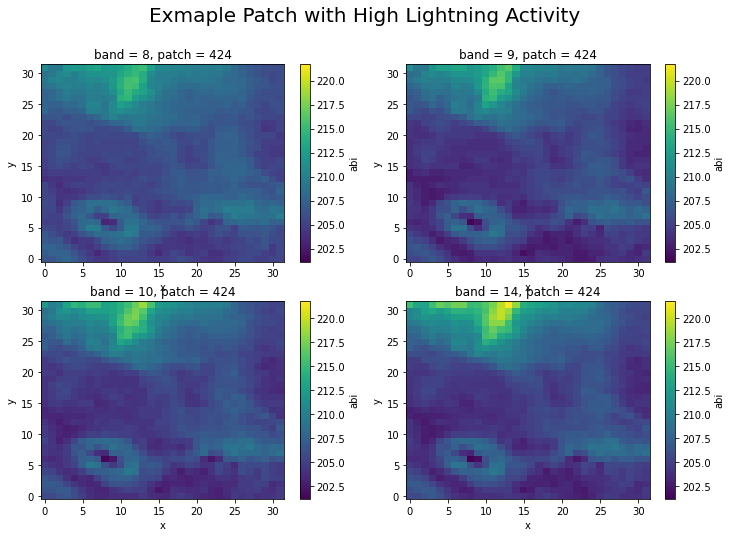

In [6]:
output_data = train['flash_counts'].values[1000:1200]
print(output_data)
high_lc_indices = np.argwhere(train.flash_counts.values > 100).flatten() # indices with more than 100 lightning counts
no_lc_indices = np.argwhere(train.flash_counts.values == 0).flatten() # indices with no lightning counts
#Just picked one at random to show what it looks like
index = high_lc_indices[205]
print(high_lc_indices[0:40])#first 40 indexes of the images with flashes
flashes=train.flash_counts.values
print(flashes[6011:6013])
vmin = train['abi'][index,:,:,:].min() # set min/max plotting range  
vmax = train['abi'][index,:,:,:].max()

fig, ax = plt.subplots(2,2, figsize=(12,8))
for i in range(4):
    train['abi'][index,i,:,:].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)
    plt.suptitle('Exmaple Patch with High Lightning Activity', fontsize=20)

Areas without lightning activity often exibit a much larger BT range throughout the channel column, particularily the longwave window (Band 14) which often has much higher values with clear skies.

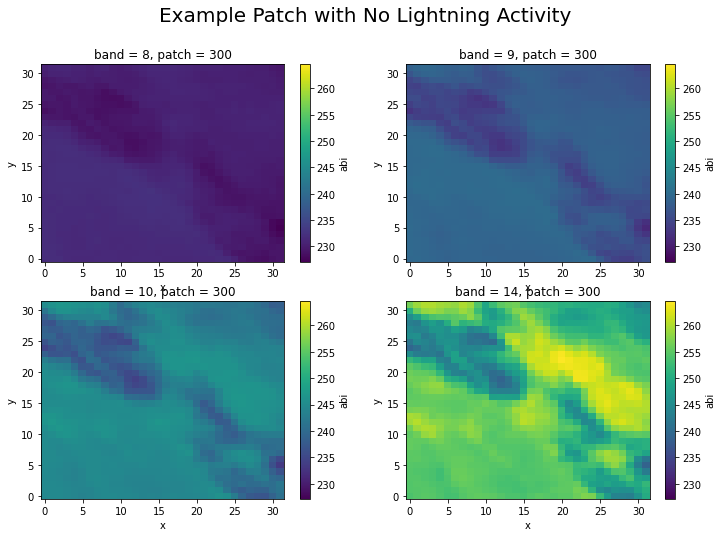

In [7]:
index = no_lc_indices[300]
vmin = train['abi'][index,:,:,:].min() # set min/max plotting range
vmax = train['abi'][index,:,:,:].max() # set min/max plotting range

fig, ax = plt.subplots(2,2, figsize=(12,8))
for i in range(4):
    train['abi'][index,i,:,:].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)
    plt.suptitle('Example Patch with No Lightning Activity', fontsize=20)

This pattern is also noted when taking the mean value of each patch across the dataset.

<xarray.DataArray 'abi' (patch: 1534, band: 4)>
array([[226.97568, 230.3917 , 233.24396, 240.04416],
       [225.62222, 228.40506, 230.45294, 235.22052],
       [225.15039, 227.84398, 229.70547, 234.11948],
       ...,
       [216.327  , 217.48193, 217.95358, 218.78714],
       [227.27576, 231.73643, 236.29272, 249.19427],
       [226.11133, 229.82828, 232.2155 , 237.14809]], dtype=float32)
Coordinates:
  * band     (band) int64 8 9 10 14
  * patch    (patch) int64 1362 1401 1461 1465 1516 ... 2363 2616 2770 3004 3455 (1534, 4)


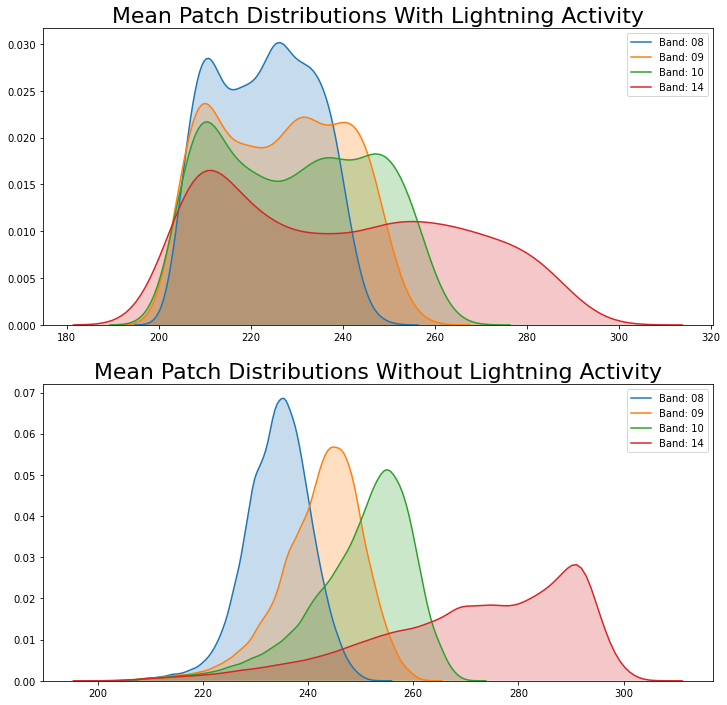

In [9]:
lc_train = train.isel(patch=high_lc_indices) # all patch data with lightning counts (above threshold)
no_lc_train = train.isel(patch=no_lc_indices) # all patch data without lightning activity
mean_patches_lc = lc_train.abi.mean(dim=('x','y')) # mean BT of each patch
mean_patches_no_lc = no_lc_train.abi.mean(dim=('x','y')) # mean BT of each patch
sd_patches_lc = lc_train.abi.std(dim=('x','y')) # standard dev BT of each patch
sd_patches_no_lc = no_lc_train.abi.std(dim=('x','y')) # standard dev BT of each patch

print(mean_patches_lc, np.shape(mean_patches_lc))
fig, ax = plt.subplots(2,1, figsize=(12,12))
for i,lab in enumerate(['Band: 08', 'Band: 09', 'Band: 10', 'Band: 14']*2):
    if i < 4:
        sns.kdeplot(mean_patches_lc[:,i], ax=ax[0], label=lab, shade=True).set_title(
            'Mean Patch Distributions With Lightning Activity', fontsize=22)
    else:
        sns.kdeplot(mean_patches_no_lc[:,i-4], ax=ax[1], label=lab, shade=True).set_title(
            'Mean Patch Distributions Without Lightning Activity', fontsize=22)

### Data Transforms
Discuss any transforms or normalizations that may be needed for this dataset. Remember to fit a scaler only to the training data and then apply it on testing and validation.

In [26]:
# Visual of input variable before and after transform
# Example of data transform procedure for dataset

In [11]:
%%time
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler
# get numpy arrays of patch data for each band (this also converts all flash_counts to binary classes)
train_in, train_out = prepare_data(train) 
val_in, val_out = prepare_data(val)
#print(train_in[0:2])


#simply a transformation of the data (value-min/max-min).Variation on the 0 mean.
# scale data
scaler = MinMaxScaler2D()
scaled_train_in = scaler.fit_transform(train_in)
scaled_val_in = scaler.transform(val_in)
print(np.shape(train_in), np.shape(scaled_train_in), np.shape(train_in[-1]))


#scalerAbs= MaxAbsScaler(train_in)
#scaled_train_inAbs = scalerAbs.fit_transform(train_in.ravel())
#scaled_val_inAbs = scalerAbs.transform(val_in.ravel())


(212604, 32, 32, 4) (212604, 32, 32, 4) (32, 32, 4)
CPU times: user 17 s, sys: 6 s, total: 23 s
Wall time: 22.9 s


In [15]:
# declare ResNet (residual network from the goes16i module) and list the default parameters
# Any of these parameters can be overridden
# note using larger batch sizes here can cause memory errors
resNet_mod = ResNet(epochs=5, batch_size=512, hidden_activation='leaky')
vars(resNet_mod)

{'min_filters': 16,
 'filter_width': 3,
 'filter_growth_rate': 2,
 'min_data_width': 4,
 'hidden_activation': 'leaky',
 'output_activation': 'sigmoid',
 'use_dropout': False,
 'pooling': 'mean',
 'dropout_alpha': 0.0,
 'data_format': 'channels_last',
 'optimizer': 'adam',
 'learning_rate': 0.001,
 'loss': 'mse',
 'metrics': None,
 'leaky_alpha': 0.1,
 'batch_size': 512,
 'epochs': 5,
 'sgd_momentum': 0.99,
 'model': None,
 'parallel_model': None,
 'time_history': <goes16ci.models.TimeHistory at 0x7fac880bc3d0>,
 'loss_history': <goes16ci.models.LossHistory at 0x7fac880bc410>,
 'verbose': 0}

In [16]:
%%time
# Fit model and print architecture
resNet_mod.fit(scaled_train_in, train_out, scaled_val_in, val_out)
resNet_mod.model.summary()

{'loss': 0.08274337649345398, 'val_loss': 0.30893102288246155}
{'loss': 0.0679803267121315, 'val_loss': 0.1306513398885727}
{'loss': 0.06439389288425446, 'val_loss': 0.11724741011857986}
{'loss': 0.06259869784116745, 'val_loss': 0.13589146733283997}
{'loss': 0.06102680042386055, 'val_loss': 0.11067362129688263}
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scn_input (InputLayer)          [(None, 32, 32, 4)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   592         scn_input[0][0]                  
__________________________________________________________________________________________________
bn_res_00_a (BatchNormalization (None, 32, 32, 16)   64          conv2d_1[0][0

## Baseline ResNet Evaluation Metrics
We trained on binary output data, but output probabilities before converting to class. This allows us to evaluate regressed and classified metrics:


| Type | Metric | Value to beat |
| ------------- | :----:|:-------|
|  Regressed   ||   
|              | RMSE: |0.328|
|              | R2: |0.567 |
|              | Hellenger Distance: |0.501|
|||
| Classified   |||
|              | Heidke Skill Score: |0.705|
|              | Peirce Skill Score:  |0.713|
|              | Brier Score: |0.143|
|              | Brier Skill Score: |0.402|
|              | AUC: |0.856|

In [16]:
# set the probability threshold for binary classification; predict on validation; add binary preds
binary_threshold = 0.5
preds = resNet_mod.predict(scaled_val_in).reshape(val_out.shape[0])
binary_preds = np.where(preds >= binary_threshold, 1, 0)

NameError: name 'resNet_mod' is not defined

In [16]:
# Metric functions
from sklearn.metrics import confusion_matrix, mean_squared_error, brier_score_loss, roc_auc_score

import numpy as np

def calc_pdf_hist(x, x_bins):
    return np.histogram(x, x_bins, density=True)[0]

def auc_score(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

def brier_score(y_true, y_pred):
    return brier_score_loss(y_true, y_pred)

def brier_skill_score(y_true, y_pred):
    
    model_brier_score = mean_squared_error(y_true, y_pred)
    climo_brier_score = mean_squared_error(y_true, np.ones(y_true.size) * y_true.sum() / y_true.size)
    model_brier_skill_score = 1 - model_brier_score / climo_brier_score
    return model_brier_skill_score

def hellinger(x, pdf_p, pdf_q):
    pdf_distances = (np.sqrt(pdf_p) - np.sqrt(pdf_q)) ** 2
    return np.trapz(pdf_distances, x) / 2

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def hellinger_distance(y_true, y_pred, bins=50):
    bin_points = np.linspace(np.minimum(y_true.min(), y_pred.min()),
                       np.maximum(y_true.max(), y_pred.max()),
                       bins)
    bin_centers = 0.5 * (bin_points[:-1] + bin_points[1:])
    y_true_pdf = calc_pdf_hist(y_true, bin_points)
    y_pred_pdf = calc_pdf_hist(y_pred, bin_points)
    return hellinger(bin_centers, y_true_pdf, y_pred_pdf)

def peirce_skill_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    n = float(cm.sum())
    nf = cm.sum(axis=0)
    no = cm.sum(axis=1)
    correct = float(cm.trace())
    return (correct / n - (nf * no).sum() / n ** 2) / (1 - (no * no).sum() / n ** 2)

def heidke_skill_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    n = float(cm.sum())
    nf = cm.sum(axis=0)
    no = cm.sum(axis=1)
    correct = float(cm.trace())
    return (correct / n - (nf * no).sum() / n ** 2) / (1 - (nf * no).sum() / n ** 2)

def r2_corr(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1] ** 2

In [20]:
# Example regressed metrics
print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(val_out, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out, preds),3)))

# Example classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(val_out, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, binary_preds),3)))
print('AUC: {}'.format(np.round(roc_auc_score(val_out, binary_preds),3)))

RMSE: 0.297
R squared: 0.331
Hellenger Distance: 0.75
Heidke Skill Score: 0.0
Pierce Skill Score: 0.0
Brier Score: 0.133
Brier Skill Score: -0.153
AUC: 0.5


## Interpretation
Description of interpretation methods for problem

In [ ]:
# Include examples of interpretation code

## Hackathon Challenges

### Monday
* Load the data
* Create an exploratory visualization of the data
* Test two different transformation and scaling methods
* Test one dimensionality reduction method
* Train a linear model
* Train a decision tree ensemble method of your choice

In [11]:
sd_patches_lc = lc_train.abi.std(dim=('x','y')) # standard dev BT of each patch
sd_patches_no_lc = no_lc_train.abi.std(dim=('x','y')) # standard dev BT of each patch


NameError: name 'lc_train' is not defined

### Tuesday
* Train a densely connected neural network
* Train a convolutional or recurrent neural network (depends on problem)
* Experiment with different architectures

In [61]:
# Tuesday's code goes here
from goes16ci.models import StandardConvNet, ResNet, MinMaxScaler2D

print(np.shape(scaled_train_in))
print(np.shape(scaled_train_in), np.shape(scaled_val_in), np.shape(train_out), np.shape(val_out), train_in[0,0,0,0:2])
print(train_in[1, :, :, 1], train_out[1])
print(train_out)

#reduce number of images due to kernel breaking
scaled_train_in=scaled_train_in[0:50000,:,:,:]
scaled_val_in=scaled_val_in[0:50000,:,:,:]
train_out=train_out[0:50000]
val_out=val_out[0:50000]
print(np.shape(scaled_train_in), np.shape(scaled_val_in), np.shape(train_out), np.shape(val_out), train_in[0,0,0,0:2])

CNN_Model=StandardConvNet(epochs=50, batch_size=512, hidden_activation='leaky', pooling='max', learning_rate=0.01)
vars(CNN_Model)
history=CNN_Model.fit(scaled_train_in, train_out, scaled_val_in, val_out)
#CNN_Model.model.summary()
print('finished')

"""
resNet_mod = ResNet(epochs=5, batch_size=512, hidden_activation='leaky')
vars(resNet_mod)
resNet_mod.fit(scaled_train_in, train_out, scaled_val_in, val_out)
resNet_mod.model.summary()
"""




(10000, 32, 32, 4)
(10000, 32, 32, 4) (10000, 32, 32, 4) (10000,) (10000,) [230.78139 236.06903]
[[236.73077 236.73077 236.62134 ... 234.24008 234.47408 234.59047]
 [236.62134 236.40147 236.1802  ... 234.47408 234.59047 234.7065 ]
 [236.40147 236.291   236.06903 ... 234.7065  234.7065  234.82213]
 ...
 [235.50783 235.39449 235.28078 ... 234.35728 234.00446 234.00446]
 [235.50783 235.50783 235.39449 ... 233.76718 233.52826 233.64793]
 [235.6208  235.6208  235.50783 ... 233.40816 233.16669 232.9235 ]] 0
[0 0 0 ... 0 0 0]
(10000, 32, 32, 4) (10000, 32, 32, 4) (10000,) (10000,) [230.78139 236.06903]
{'loss': 0.19315499067306519, 'val_loss': 0.13269999623298645}
{'loss': 0.1891999989748001, 'val_loss': 0.13269999623298645}
{'loss': 0.1891999989748001, 'val_loss': 0.13269999623298645}
{'loss': 0.1891999989748001, 'val_loss': 0.13269999623298645}
{'loss': 0.1891999989748001, 'val_loss': 0.13269999623298645}
{'loss': 0.1891999989748001, 'val_loss': 0.13269999623298645}
{'loss': 0.1891999989748

"\nresNet_mod = ResNet(epochs=5, batch_size=512, hidden_activation='leaky')\nvars(resNet_mod)\nresNet_mod.fit(scaled_train_in, train_out, scaled_val_in, val_out)\nresNet_mod.model.summary()\n"

### Wednesday
* Calculate three relevant evaluation metrics for each ML solution and baseline
* Refine machine learning approaches and test additional hyperparameter settings

In [62]:
# set the probability threshold for binary classification; predict on validation; add binary preds
binary_threshold = 0.5
preds = CNN_Model.predict(scaled_val_in).reshape(val_out.shape[0])
binary_preds = np.where(preds >= binary_threshold, 1, 0)


# Wednesday's code goes here
print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(val_out, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out, preds),3)))

# Example classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(val_out, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, binary_preds),3)))
print('AUC: {}'.format(np.round(roc_auc_score(val_out, binary_preds),3)))

RMSE: 0.364
R squared: 0.002
Hellenger Distance: 0.034
Heidke Skill Score: 0.0
Pierce Skill Score: 0.0
Brier Score: 0.133
Brier Skill Score: -0.153
AUC: 0.5


### Thursday 
* Evaluate two interpretation methods for your machine learning solution
* Compare interpretation of baseline with your approach
* Submit best results on project to leaderboard
* Prepare 2 Google Slides on team's approach and submit them 

dict_keys(['loss', 'val_loss'])


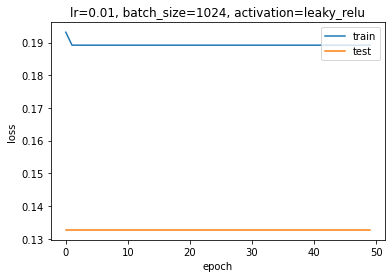

In [63]:
#fit the model (after compiling)
#history = CNN_Model.fit(scaled_train_in, train_out, scaled_val_in, val_out)
history.history
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('lr=0.01, batch_size=512, activation=leaky_relu')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Ultimate Submission Code
Please insert your full data processing and machine learning pipeline code in the cell below.